# Bayesian MNIST CNN
This notebook will train a vanilla classifier and a Bayesian one.

#### References
* [Bayesian CNN with Tensorflow](https://medium.com/python-experiments/bayesian-cnn-model-on-mnist-data-using-tensorflow-probability-compared-to-cnn-82d56a298f45)
* [Tensorflow CNN](https://www.tensorflow.org/tutorials/images/cnn)
* [Tensorflow Probability Sample](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py)
* [Sample but with Issue](https://github.com/tensorflow/probability/issues/511)

In [92]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
import datetime
import os
from tensorflow import keras
EPOCHS = 5
BATCH_SIZE = 64

print('Tensorflow version:', tf.__version__, 'eagerMode:', tf.executing_eagerly())
print('GPU available:', tf.test.is_gpu_available())
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus)
global_batch_size = (BATCH_SIZE * num_gpus)

!rm -rf logs
!rm -rf checkpoints

Tensorflow version: 2.1.0 eagerMode: True
GPU available: False
Num GPUs Available:  0


#### Load MNIST data

In [93]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


#### Baseline Model MLP
Accuracy around 97%

In [94]:
# Notice that we don't need to care about the batch_size and also we don't need
# to calculate the layer input sizes
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(64, input_shape=(784,), activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# Train
log_dir="logs_baseline/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 42us/sample - loss: 0.3545 - accuracy: 0.8991 - val_loss: 0.2034 - val_accuracy: 0.9404
Epoch 2/5
48000/48000 [==========================

#### CNN Model
Accuracy around 99%

In [95]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# Train
log_dir="logs_cnn/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)              

#### Using Tensorflow Probability

In [96]:
NUM_TRAIN_EXAMPLES = 6000
kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

model = keras.Sequential([
    tfp.layers.Convolution2DReparameterization(32, (3,3), activation='relu', input_shape=(28, 28, 1), kernel_divergence_fn=kl_divergence_function), 
    keras.layers.MaxPooling2D((2, 2)),
    tfp.layers.Convolution2DReparameterization(64, (3, 3), activation='relu', kernel_divergence_fn=kl_divergence_function),
    keras.layers.MaxPooling2D((2, 2)),
    tfp.layers.Convolution2DReparameterization(64, (3, 3), activation='relu', kernel_divergence_fn=kl_divergence_function),
    keras.layers.Flatten(),
    tfp.layers.DenseFlipout(64, activation='relu', kernel_divergence_fn=kl_divergence_function),
    tfp.layers.DenseFlipout(10, activation='softmax', kernel_divergence_fn=kl_divergence_function)
])

model.summary()

def neg_log_likelihood_bayesian(y_true, y_pred):
            labels_distribution = tfp.distributions.Categorical(logits=y_pred)
            log_likelihood = labels_distribution.log_prob(tf.argmax(input=y_true, axis=1))
            loss = -tf.reduce_mean(input_tensor=log_likelihood)
            return loss

model.compile(loss='sparse_categorical_crossentropy',#neg_log_likelihood_bayesian,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], experimental_run_tf_function=False)

# Train
log_dir="logs_cnn_bayesian/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_21 (None, 26, 26, 32)        608       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_reparameterization_22 (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_reparameterization_23 (None, 3, 3, 64)          73792     
_________________________________________________________________
flatten_13 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_flipout_14 (DenseFlipo (None, 64)              

Sample shape: (28, 28, 1)


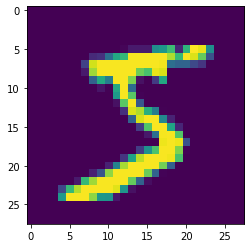

In [102]:
sample = x_train[0]
print('Sample shape:', sample.shape)
plt.imshow(sample.squeeze(axis=2))
plt.show()

In [98]:
#predictions = [np.argmax(model(tf.expand_dims(sample, axis=0)).numpy()) for i in range(100)]
#predictions = [model(tf.expand_dims(sample, axis=0)).numpy() for i in range(100)]
#predictions = [probability_model(tf.expand_dims(x_train[0], axis=0)).numpy() for i in range(100)]

#### Monte Carlo Inference
The probabilistic model will give different results for each 

In [99]:
# Convert logits to probabilities
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
probabilities = [probability_model(tf.expand_dims(sample, axis=0)).numpy() for i in range(100)]

/mnt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: tight_layout : falling back to Agg renderer
  # Remove the CWD from sys.path while we load stuff.


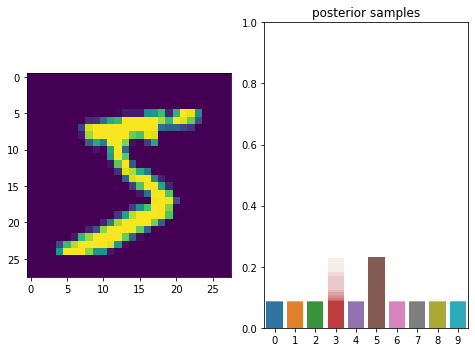

In [100]:
fig = figure.Figure(figsize=(10, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(sample.squeeze(axis=2), interpolation='None')
ax = fig.add_subplot(1, 3, 2)
for prob in probabilities:
    sns.barplot(np.arange(10), prob[0, :], alpha=0.1, ax=ax)
    ax.set_ylim([0, 1])
ax.set_title('posterior samples');

fig.tight_layout()
fig

Sample shape: (28, 28, 1)


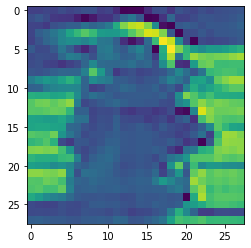

In [110]:
from PIL import Image
sample = np.asarray(Image.open("BabyYoda_small.jpg").convert('L'))
plt.imshow(sample)
sample = np.expand_dims(sample, axis=2).astype(np.float32)
print('Sample shape:', sample.shape)

In [111]:
# Convert logits to probabilities
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
probabilities = [probability_model(tf.expand_dims(sample, axis=0)).numpy() for i in range(100)]

/mnt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: tight_layout : falling back to Agg renderer
  # Remove the CWD from sys.path while we load stuff.


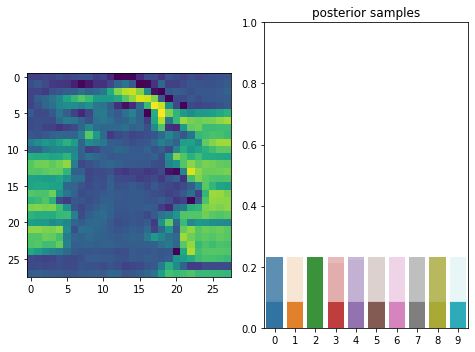

In [112]:
fig = figure.Figure(figsize=(10, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(sample.squeeze(axis=2), interpolation='None')
ax = fig.add_subplot(1, 3, 2)
for prob in probabilities:
    sns.barplot(np.arange(10), prob[0, :], alpha=0.1, ax=ax)
    ax.set_ylim([0, 1])
ax.set_title('posterior samples');

fig.tight_layout()
fig